<a href="https://colab.research.google.com/github/souro26/bayesian-a-b-testing/blob/main/Bayesian_A_B_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian A/B Testing Tool

This tool uses **Beta-Binomial conjugate priors** for exact Bayesian inference on conversion rates.

Instead of p-values, we get:
- Probability that variant B beats A
- Expected lift with credible intervals
- Clear decision recommendations

**Method:** Direct Bayesian inference (no MCMC required for binary outcomes)

In [ ]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

In [ ]:
#@title ### 📊 Input Parameters
#@markdown **Variant A:**

n_A = 10000 #@param {type:"number"}
x_A = 2634 #@param {type:"number"}

#@markdown **Variant B:**

n_B = 10000 #@param {type:"number"}
x_B = 2853 #@param {type:"number"}

#@markdown **Prior Selection:**
prior_type = "Uniform (uninformative)" #@param ["Uniform (uninformative)", "Weakly informative"]

if prior_type == "Uniform (uninformative)":
    alpha_prior = 1
    beta_prior = 1
else:
    alpha_prior = 10
    beta_prior = 10

# Validation
if x_A > n_A:
    print("⚠️ Warning: Conversions A cannot exceed visitors A")
    x_A = n_A
if x_B > n_B:
    print("⚠️ Warning: Conversions B cannot exceed visitors B")
    x_B = n_B

print("="*50)
print("EXPERIMENT DATA")
print("="*50)
print(f"Variant A: {x_A:,} conversions / {n_A:,} visitors = {x_A/n_A*100:.2f}%")
print(f"Variant B: {x_B:,} conversions / {n_B:,} visitors = {x_B/n_B*100:.2f}%")
print(f"Prior: Beta({alpha_prior}, {beta_prior})")
print("="*50)

EXPERIMENT DATA
Variant A: 2,634 conversions / 10,000 visitors = 26.34%
Variant B: 2,853 conversions / 10,000 visitors = 28.53%
Prior: Beta(1, 1)


## Step 1: Computing Posterior Distributions

We update our prior beliefs with observed data using Bayes' theorem.

For each variant, the **posterior distribution** is:
- **Prior**: Beta(α, β)
- **Likelihood**: Binomial(n, p)
- **Posterior**: Beta(α + x, β + n - x)

This conjugacy allows exact computation without sampling.

In [ ]:
def bayesian_ab_test(
    n_A, x_A,
    n_B, x_B,
    alpha_prior=1,
    beta_prior=1,
    n_samples=10000
):
    """
    Performs Bayesian A/B test using Beta-Binomial model.

    Returns dict with probability B beats A, lift statistics, and samples.
    """
    # Posterior distributions
    posterior_A = beta(alpha_prior + x_A, beta_prior + n_A - x_A)
    posterior_B = beta(alpha_prior + x_B, beta_prior + n_B - x_B)

    # Monte Carlo sampling
    samples_A = posterior_A.rvs(n_samples)
    samples_B = posterior_B.rvs(n_samples)

    # Probability B is better than A
    prob_B_better = np.mean(samples_B > samples_A)

    # Lift distribution
    lift = (samples_B - samples_A) / samples_A
    lift_mean = lift.mean()
    lift_ci = np.percentile(lift, [2.5, 97.5])

    # Absolute difference
    abs_diff = samples_B - samples_A
    abs_diff_mean = abs_diff.mean()

    return {
        "prob_B_better": prob_B_better,
        "lift_mean": lift_mean,
        "lift_ci": lift_ci,
        "abs_diff_mean": abs_diff_mean,
        "samples_A": samples_A,
        "samples_B": samples_B,
        "lift_samples": lift,
        "posterior_A": posterior_A,
        "posterior_B": posterior_B
    }

In [ ]:
def decision_rule(prob_B_better, lift_ci, lift_mean):
    if prob_B_better > 0.95 and lift_ci[0] > 0:
        confidence = "STRONG"
        decision = "LAUNCH VARIANT B"
        explanation = "High confidence that B is better, with positive minimum lift."
    elif prob_B_better < 0.05 and lift_ci[1] < 0:
        confidence = "STRONG"
        decision = "KEEP VARIANT A"
        explanation = "High confidence that A is better."
    elif prob_B_better > 0.75:
        confidence = "MODERATE"
        decision = "LEAN TOWARDS B (collect more data)"
        explanation = "Moderate evidence for B, but credible interval includes negatives."
    elif prob_B_better < 0.25:
        confidence = "MODERATE"
        decision = "LEAN TOWARDS A (collect more data)"
        explanation = "Moderate evidence for A."
    else:
        confidence = "WEAK"
        decision = "INCONCLUSIVE - COLLECT MORE DATA"
        explanation = "Insufficient evidence to make a decision."

    return decision, confidence, explanation

In [ ]:
# Run Bayesian A/B test
results = bayesian_ab_test(
    n_A, x_A,
    n_B, x_B,
    alpha_prior=alpha_prior,
    beta_prior=beta_prior
)

decision, confidence, explanation = decision_rule(
    results["prob_B_better"],
    results["lift_ci"],
    results["lift_mean"]
)

# Print Results
print("\n" + "="*60)
print("BAYESIAN A/B TEST RESULTS")
print("="*60)
print(f"\n Probability B Beats A:  {results['prob_B_better']:.1%}")
print(f" Expected Relative Lift: {results['lift_mean']:+.2%}")
print(f" 95% Credible Interval:  [{results['lift_ci'][0]:+.2%}, {results['lift_ci'][1]:+.2%}]")
print(f" Absolute Difference:    {results['abs_diff_mean']:+.4f} (percentage points)")

print(f"\n{'─'*60}")
print(f"DECISION: {decision}")
print(f"Confidence: {confidence}")
print(f"Reasoning: {explanation}")
print("="*60 + "\n")


BAYESIAN A/B TEST RESULTS

 Probability B Beats A:  100.0%
 Expected Relative Lift: +8.34%
 95% Credible Interval:  [+3.69%, +13.17%]
 Absolute Difference:    +0.0219 (percentage points)

────────────────────────────────────────────────────────────
DECISION: LAUNCH VARIANT B
Confidence: STRONG
Reasoning: High confidence that B is better, with positive minimum lift.



In [ ]:
def plot_posteriors(posterior_A, posterior_B):
    """Plot posterior distributions of conversion rates."""
    x = np.linspace(0.15, 0.45, 1000)

    plt.figure(figsize=(12, 6))
    plt.plot(x, posterior_A.pdf(x), label="Variant A", linewidth=2.5, color='#3B82F6')
    plt.plot(x, posterior_B.pdf(x), label="Variant B", linewidth=2.5, color='#8B5CF6')

    plt.axvline(posterior_A.mean(), color='#3B82F6', linestyle='--', alpha=0.5, label=f'A Mean: {posterior_A.mean():.3f}')
    plt.axvline(posterior_B.mean(), color='#8B5CF6', linestyle='--', alpha=0.5, label=f'B Mean: {posterior_B.mean():.3f}')

    plt.xlabel("Conversion Rate", fontsize=12)
    plt.ylabel("Probability Density", fontsize=12)
    plt.title("Posterior Distributions of Conversion Rates", fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_lift_distribution(lift_samples, lift_mean, lift_ci):
    """Plot distribution of relative lift."""
    plt.figure(figsize=(12, 6))
    plt.hist(lift_samples, bins=60, density=True, alpha=0.7, color='#6366F1', edgecolor='black')

    plt.axvline(0, color="black", linestyle="--", linewidth=2, label="No Effect", alpha=0.7)
    plt.axvline(lift_mean, color="red", linestyle="--", linewidth=2, label=f"Expected Lift: {lift_mean:+.2%}")
    plt.axvline(lift_ci[0], color="orange", linestyle=":", linewidth=1.5, alpha=0.7, label=f"95% CI")
    plt.axvline(lift_ci[1], color="orange", linestyle=":", linewidth=1.5, alpha=0.7)

    plt.xlabel("Relative Lift (%)", fontsize=12)
    plt.ylabel("Probability Density", fontsize=12)
    plt.title("Posterior Distribution of Relative Lift", fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

Generating visualizations...



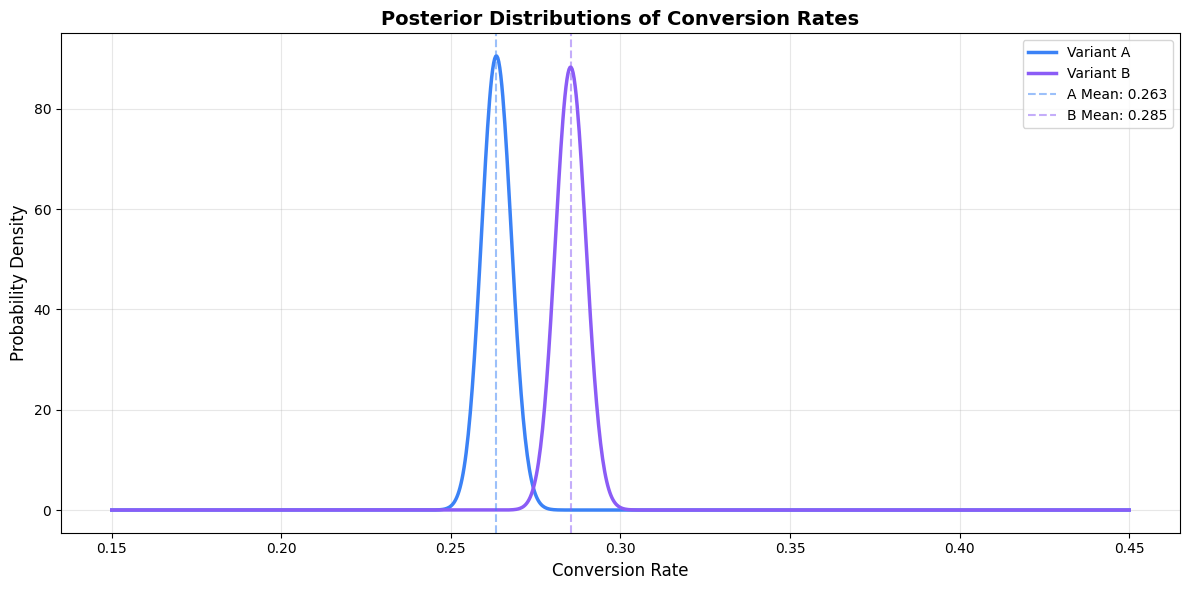

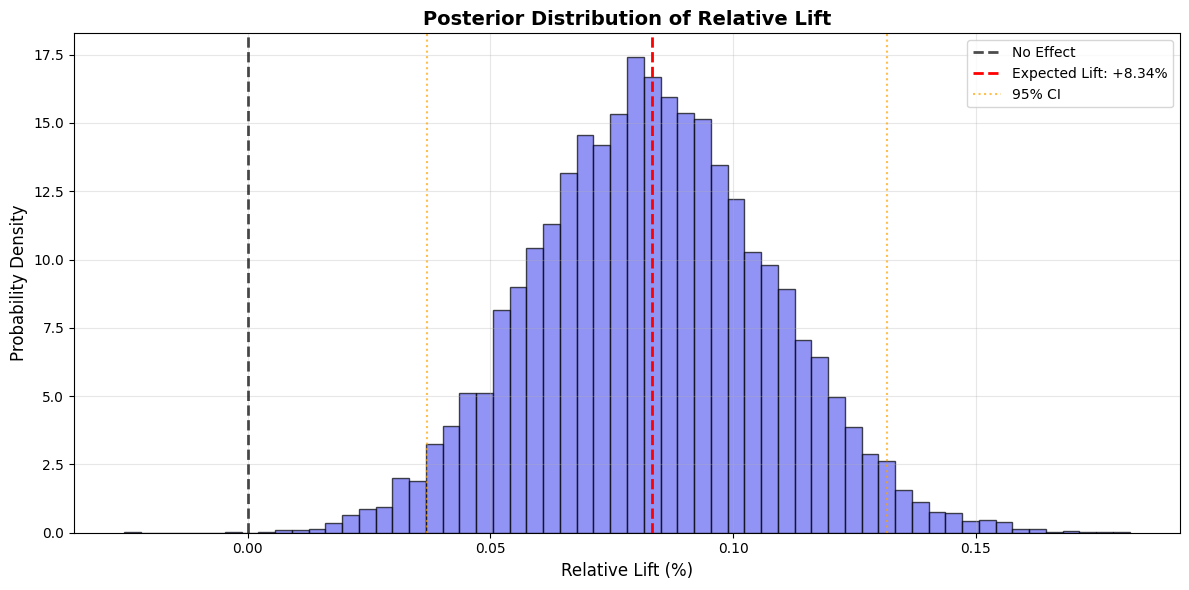

Analysis complete!


In [ ]:
print("Generating visualizations...\n")

# Plot 1: Posterior distributions
plot_posteriors(results["posterior_A"], results["posterior_B"])

# Plot 2: Lift distribution
plot_lift_distribution(
    results["lift_samples"],
    results["lift_mean"],
    results["lift_ci"]
)

print("Analysis complete!")